In [28]:
# Import libaries
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import time
import datetime
import requests
import gmplot
from mpl_toolkits.basemap import Basemap

In [594]:
# !pip install gmplot

In [595]:
# !pip install python-twitter

In [29]:
import twitter
api = twitter.Api(consumer_key='YfkfmWvtZAz7SS9GHRZzpleNc',
                  consumer_secret='O9sQl3eHtq6EMbKh5vsvLwaaiLXRKNVhfd50mb7yEa83LX6NPK',
                  access_token_key='2453541001-sJHmhzs9LD7y37FIJTuQQDMXEhybFpIqTGuEkHG',
                  access_token_secret='VR0tUAq74JTW5bmkKtyPwdjBBOkVMAV0eKBL8pU2wmMAm')

In [30]:
print(api.VerifyCredentials())

{"created_at": "Sat Apr 19 18:21:11 +0000 2014", "default_profile": true, "default_profile_image": true, "friends_count": 7, "geo_enabled": true, "id": 2453541001, "id_str": "2453541001", "name": "Andy", "profile_background_color": "C0DEED", "profile_background_image_url": "http://abs.twimg.com/images/themes/theme1/bg.png", "profile_background_image_url_https": "https://abs.twimg.com/images/themes/theme1/bg.png", "profile_image_url": "http://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png", "profile_image_url_https": "https://abs.twimg.com/sticky/default_profile_images/default_profile_normal.png", "profile_link_color": "1DA1F2", "profile_sidebar_border_color": "C0DEED", "profile_sidebar_fill_color": "DDEEF6", "profile_text_color": "333333", "profile_use_background_image": true, "screen_name": "kuduhe"}


In [31]:
def create_table(x):
    result = {
        'created':[],
        'text':[],
        'location':[],
        'hashtags':[]
    }
    for i in range(len(x)):
        result['created'].append(pd.Timestamp(x[i].created_at_in_seconds, unit='s'))
        result['text'].append(x[i].text)
        result['location'].append(x[i].geo)
        result['hashtags'].append(x[i].hashtags)
    return pd.DataFrame(result, columns = ['created','text','location','hashtags'])

In [32]:
def get_data(term = None, since = None, until = None, geocode = None,):
    output = pd.DataFrame()
    for i in range(1):
        search = api.GetSearch(term, since = since, until = until, geocode = geocode, lang='en',count = 100)
        output = pd.concat([output, create_table(search)], axis = 0)
        time.sleep(3)
        print(f'Fetching data {(i+1)*100}')
    return output

In [200]:
# from zipfile import ZipFile

In [593]:
# !pip install fastkml

In [41]:
#https://www.ospo.noaa.gov/Products/land/hms.html
#queto from

In [33]:
def reset_today():
    url = 'https://satepsanone.nesdis.noaa.gov/pub/FIRE/HMS/KML/'
    today = str(datetime.datetime.today().date().year)+str(datetime.datetime.today().date().month)+str(datetime.datetime.today().date().day)
    return requests.get(url+f'fire{today}.kml').content

In [34]:
today = reset_today()

In [270]:

# from fastkml import kml
# k = kml.KML()
# with open('./data/fire20191026.kml','r') as myfile:
#     data = myfile.read().encode('utf-8')
# k.from_string(data)
# stk = k.to_string(prettyprint=True)    

In [35]:
def livefire(x):
    soup = BeautifulSoup(x, 'lxml')
    raw = soup.find_all(['coordinates','description'])
    firecorr = []
    for i in range(0, len(raw),2):
        date = raw[i].text.split()[3] + raw[i].text.split()[5]
        cord = raw[i+1].text.split(',')[:-1]
        d1 = datetime.datetime(int(date[0:4]), 1, 1) + datetime.timedelta(int(date[4:7]) - 1)
        d2 = pd.to_datetime(d1)
        d2 = d2.replace(hour = int(date[7:9]), minute = int(date[9:11]))
        firecorr.append(list([d2])+cord)
    return pd.DataFrame(firecorr, columns = ['Time','Longitude','Latitude'])

In [36]:
df = livefire(today)

In [37]:
def cleandf(df):
#     df.drop_duplicates('Time', inplace = True)
    df['Longitude'] = round(df['Longitude'].astype(float),3)
    df['Latitude'] = round(df['Latitude'].astype(float),3)
    df['Longituder'] = round(df['Longitude'].astype(float),0)
    df['Latituder'] = round(df['Latitude'].astype(float),0)
    df.drop_duplicates(['Longituder','Latituder'], inplace = True)
    df = df[(df['Longitude']<-60) | (df['Longitude']>-130)]
    df = df[(df['Latitude']<50) | (df['Latitude']>20)]
    df.drop(['Longituder','Latituder'], axis = 1, inplace = True)
    return df.sort_values('Time', ascending = False)

In [38]:
dfc = cleandf(df)

In [23]:
dfc.head()

,Time,Longitude,Latitude
663,2019-10-27 10:36:00,-124.567,49.334
675,2019-10-27 10:36:00,-121.290,39.166
674,2019-10-27 10:36:00,-122.854,40.132
669,2019-10-27 10:36:00,-121.982,42.756
668,2019-10-27 10:36:00,-123.109,44.105
...,...,...,...
57,2019-10-27 06:33:00,-86.110,15.584
55,2019-10-27 06:27:00,-87.824,19.356
54,2019-10-27 06:21:00,-83.247,38.786
1058,2019-10-27 06:00:00,-122.254,39.984


In [39]:
def mapping(dfc,i):
    plt.figure(figsize = (15,13))
    m = Basemap( projection = 'mill',
               llcrnrlat= 20,
               llcrnrlon= -130,
               urcrnrlat=50,
               urcrnrlon=-60,
               resolution='l')
    m.drawcoastlines()
    m.drawcountries(linewidth = 2)
    m.drawstates(color = 'b')
    x,y = m(list(dfc['Longitude']),list(dfc['Latitude']))
    x1,y1 = m(dfc.loc[i,'Longitude'],dfc.loc[i,'Latitude'])

    m.plot(x,y, 'X', markersize = 10, color = 'orange')
    m.plot(x1,y1, "*", markersize = 20, color = 'red')
    plt.title('Live Fire Map');

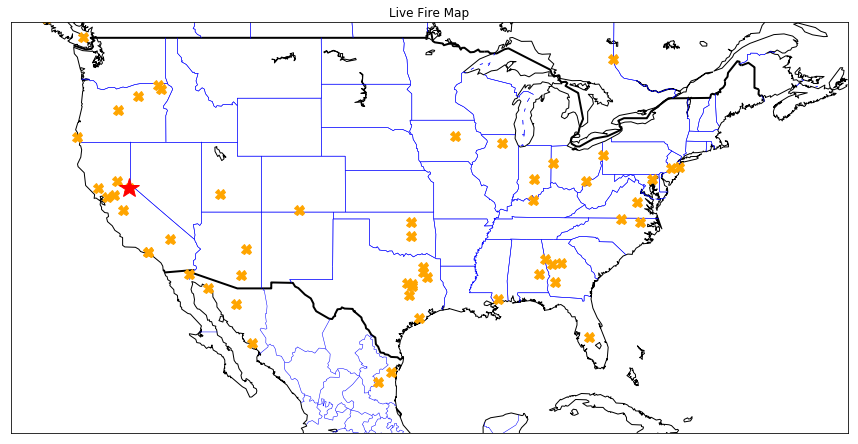

In [40]:
mapping(dfc,dfc.index[4])

In [536]:
# gmap1 = gmplot.GoogleMapPlotter(18.3805009999999989,-70.0792999999999893,13)
# gmap1.draw("emptymap.html" ) 

In [647]:
coordinates[2]

'26.06397373846659,-97.93452382528744,10mi'

In [26]:
def searchfire(dfc,radia = 5):
    coordinates = []
    result = pd.DataFrame()
    for i in dfc.index:
        coordinates.append(f"{dfc.loc[i,'Latitude']},{dfc.loc[i,'Longitude']},{radia}mi")
    for j in range(len(coordinates)):
        dfj = get_data(geocode=coordinates[j])
        dfj['location#'] = j
        result = pd.concat([result,dfj], axis = 0)
    return result

In [786]:
firetweet2 = searchfire(dfc,radia = 10)

Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching data 100
Fetching d

In [789]:
# firetweet2.to_csv('./data/20191026firedata2.csv')

In [27]:
firetweet2['location#'].value_counts()

NameError: name 'firetweet2' is not defined

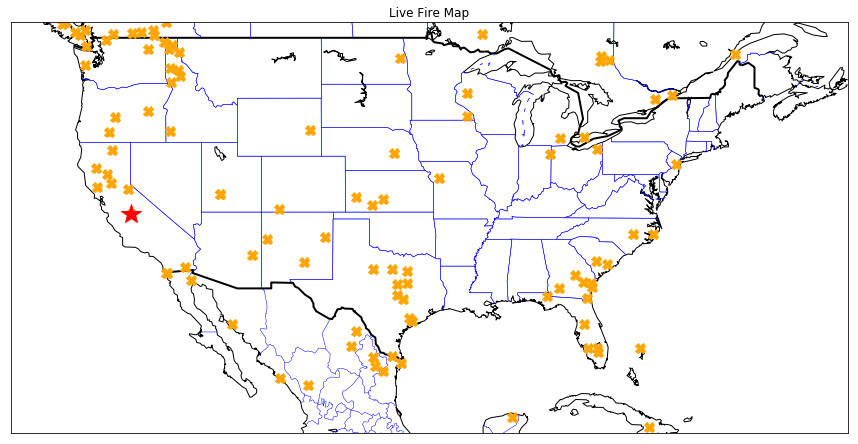

In [794]:
mapping(dfc,dfc.index[63])

# This is for earthquake project

In [82]:
# ur ='https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/2.5_day.csv'
# data = pd.read_csv(ur)

In [81]:
# data

In [71]:
# data = data[['time','longitude','latitude']]

In [72]:
# data.columns = ['Time','Longitude','Latitude']

In [80]:
# abc = searchfire(data)

In [79]:
# abc.to_csv('./data/earthquake.csv')

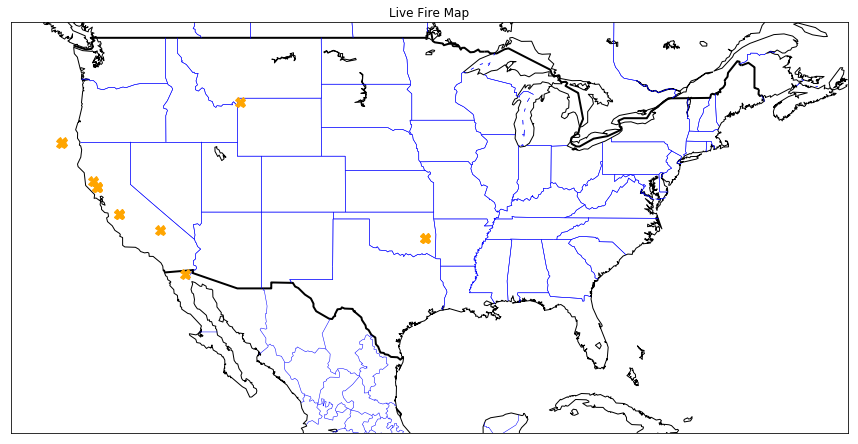

In [77]:
# mapping(data,data.index[1])
